## Настройки/Гиперпараметры/Импорты

In [133]:
import pandas as pd
import numpy as np
import re
import psutil
from pandarallel import pandarallel
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn import metrics
from varname import nameof #Преобразовать имя переменной в строку

In [108]:
print('Количество доступных потоков: ', psutil.cpu_count(logical=False))

Количество доступных потоков:  4


In [1]:
!where python

c:\Users\user\anaconda3\python.exe
C:\Users\user\VSCode\Setting for C++\ucrt64\bin\python.exe


### 1) Очистка данных

In [109]:
data = pd.read_json("data.jsonl", lines=True)
data

,text,label
0,i feel awful about it too because it s my job ...,0
1,im alone i feel awful,0
2,ive probably mentioned this before but i reall...,1
3,i was feeling a little low few days back,0
4,i beleive that i am much more sensitive to oth...,2
...,...,...
416804,that was what i felt when i was finally accept...,1
416805,i take every day as it comes i m just focussin...,4
416806,i just suddenly feel that everything was fake,0
416807,im feeling more eager than ever to claw back w...,1


In [110]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


In [111]:
data = data[data["label"].notnull()]
data = data[data["text"].notnull()]

In [112]:
data.describe()

,label
count,416809.000000
mean,1.554271
std,1.490453
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,5.000000


In [113]:
data["label"].value_counts()

1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: label, dtype: int64

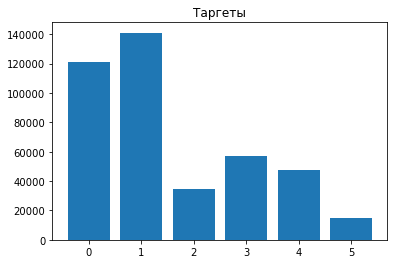

In [114]:
plt.bar(data["label"].value_counts().index, data["label"].value_counts())
plt.title("Таргеты")
plt.show()

In [115]:
pandarallel.initialize(progress_bar=True)

def clear_data(df: pd.DataFrame, variant) -> pd.DataFrame:
    import re
    from nltk.tokenize import word_tokenize
    stop_words = stopwords.words('english')
    
    lemmatizer = WordNetLemmatizer()
    df['text'] = df['text'].parallel_apply(lambda text: text.lower())
    
    if variant == 'http' or variant == 'all':
        df['text'] = df['text'].parallel_apply(lambda text: re.sub("http\S*", ' ', text))
    
    if variant == 'punct' or variant == 'all':
        df['text'] = df['text'].parallel_apply(lambda text: re.sub(r"[,.…?:;¦/\\!@#$#—+=ツ►๑۞۩•«»“”˜°*`\"'™)(<>\[\]%$&]", '', text))
        df['text'] = df['text'].parallel_apply(lambda text: re.sub("-", ' ', text))
    
    df['text'] = df['text'].parallel_apply(lambda text: word_tokenize(text))
    df['text'] = df['text'].parallel_apply(lambda text: [lemmatizer.lemmatize(word) for word in text])
    
    if variant == 'stop words' or variant == 'all':
        df['text'] = df['text'].parallel_apply(lambda text: [word for word in text if word not in stop_words])
    
    df['text'] = df['text'].parallel_apply(lambda text: ' '.join(text))
    df['text'] = df['text'].astype('string')
    df = df[df['text'] != ""]
    df.reset_index(drop=True, inplace=True)
    return df

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [139]:
dataset_cleared_http = clear_data(data.copy(), 'http')
dataset_cleared_punct = clear_data(data.copy(), 'punct')
dataset_cleared_stop_words = clear_data(data.copy(), 'stop words')
dataset_cleared_all = clear_data(data.copy(), 'all')

In [140]:
dataset_cleared_all

,text,label
0,feel awful job get position succeed happen,0
1,im alone feel awful,0
2,ive probably mentioned really feel proud actua...,1
3,wa feeling little low day back,0
4,beleive much sensitive people feeling tend com...,2
...,...,...
416789,wa felt wa finally accepted bulgarian conserva...,1
416790,take every day come focussing eating better mo...,4
416791,suddenly feel everything wa fake,0
416792,im feeling eager ever claw back went pear shap...,1


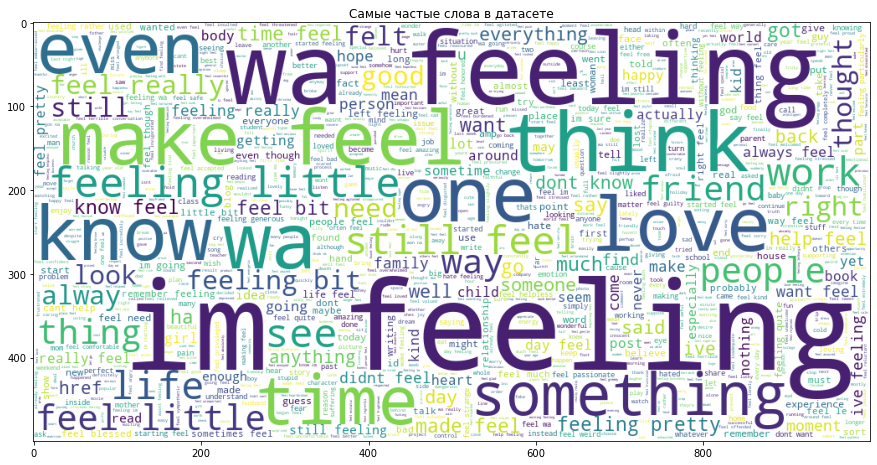

In [118]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', width=1000, height=500, random_state=42)
wordcloud.generate(" ".join(dataset_cleared_all["text"]))

plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.title("Самые частые слова в датасете")
plt.show()

### 2) Обучение моделей

In [141]:
dataset_cleared_all["label"].value_counts()

1    141065
0    121183
3     57311
4     47709
2     34554
5     14972
Name: label, dtype: int64

In [142]:
def resample_data(dataset: pd.DataFrame) -> pd.DataFrame:
    vectorizer = vectorizer = TfidfVectorizer(min_df=20, max_df=0.5, max_features=1000)
    data_vectorizer = vectorizer.fit_transform(dataset["text"]).toarray()
    data_vectorizer_frame = pd.DataFrame(data=data_vectorizer)
    newdata = pd.concat([data_vectorizer_frame,  dataset['label']], axis=1)
    dataset_up_sample = pd.DataFrame(columns=[*range(data_vectorizer.shape[1]), "label"])
    for label_value in newdata["label"].unique():
        dataset_0 = newdata[newdata['label'] == label_value]
        dataset_0 = resample(dataset_0, replace=True, n_samples=20000, random_state=42)
        dataset_up_sample = pd.concat([dataset_up_sample, dataset_0])
    return dataset_up_sample

In [143]:
dataset_cleared_http = resample_data(dataset_cleared_http)
dataset_cleared_punct = resample_data(dataset_cleared_punct)
dataset_cleared_stop_words = resample_data(dataset_cleared_stop_words)
dataset_cleared_all = resample_data(dataset_cleared_all)

In [144]:
dataset_cleared_all

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,label
54185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2956,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
355970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
412228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
378437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63716,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
16285,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
309211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
65693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


#### Модели

In [145]:
data_for_model = {}

In [147]:
Y = dataset_cleared_http['label'].values
del dataset_cleared_http['label']
data_for_model[nameof(dataset_cleared_http)] = {}
data_for_model[nameof(dataset_cleared_http)]["X_train"], data_for_model[nameof(dataset_cleared_http)]["X_test"], data_for_model[nameof(dataset_cleared_http)]["y_train"], data_for_model[nameof(dataset_cleared_http)]["y_test"] = train_test_split(dataset_cleared_http, Y, test_size=0.2, random_state=42)

In [148]:
Y = dataset_cleared_punct['label'].values
del dataset_cleared_punct['label']
data_for_model[nameof(dataset_cleared_punct)] = {}
data_for_model[nameof(dataset_cleared_punct)]["X_train"], data_for_model[nameof(dataset_cleared_punct)]["X_test"], data_for_model[nameof(dataset_cleared_punct)]["y_train"], data_for_model[nameof(dataset_cleared_punct)]["y_test"] = train_test_split(dataset_cleared_punct, Y, test_size=0.2, random_state=42)

In [149]:
Y = dataset_cleared_stop_words['label'].values
del dataset_cleared_stop_words['label']
data_for_model[nameof(dataset_cleared_stop_words)] = {}
data_for_model[nameof(dataset_cleared_stop_words)]["X_train"], data_for_model[nameof(dataset_cleared_stop_words)]["X_test"], data_for_model[nameof(dataset_cleared_stop_words)]["y_train"], data_for_model[nameof(dataset_cleared_stop_words)]["y_test"] = train_test_split(dataset_cleared_stop_words, Y, test_size=0.2, random_state=42)

In [150]:
Y = dataset_cleared_all['label'].values
del dataset_cleared_all['label']
data_for_model[nameof(dataset_cleared_all)] = {}
data_for_model[nameof(dataset_cleared_all)]["X_train"], data_for_model[nameof(dataset_cleared_all)]["X_test"], data_for_model[nameof(dataset_cleared_all)]["y_train"], data_for_model[nameof(dataset_cleared_all)]["y_test"] = train_test_split(dataset_cleared_all, Y, test_size=0.2, random_state=42)

In [170]:
data_for_model[nameof(dataset_cleared_all)]

{'X_train':         0    1    2    3    4    5    6    7    8    9    ...  990  991  992  \
 372941  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
 53574   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
 72965   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
 248889  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
 35763   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
 ...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
 1313    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
 136895  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
 386942  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
 342031  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
 332813  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
 
         993  9

In [169]:
def Stacking_ensemble_simple(X_train, X_test, y_train, y_test):
    params = [{
    # параметры KNN
    'knn_1__n_neighbors': [3],
    'knn_1__weights': ['distance'],
    'knn_1__metric': ['minkowski'],
    'knn_1__p': [2],
    'knn_1__algorithm': ['auto'],

    # параметры Decision Tree
    'dt_1__criterion': ['entropy'],
    'dt_1__max_depth': [20],
    'dt_1__min_samples_split': [10],
    'dt_1__max_features': [None],
    'dt_1__class_weight': ['balanced'],
    'dt_1__random_state': [42],

    # параметры Multinomial Naive Bayes
    "mnb_1__alpha": [1.0],
    "mnb_1__force_alpha": [True],
    "mnb_1__fit_prior": [True],
    "mnb_1__class_prior": [None],

    # параметры Logistic Regression
    "final_estimator__penalty": ["l2"],
    "final_estimator__C": [1.0],
    "final_estimator__class_weight": ["balanced"],
    "final_estimator__solver": ["lbfgs"],
    "final_estimator__max_iter": [500],
    "final_estimator__warm_start": [False],
    "final_estimator__random_state": [42]
    }]

    layer_one_estimators = [
                        ('knn_1', KNeighborsClassifier()),
                        ('dt_1', DecisionTreeClassifier()),
                        ('mnb_1', MultinomialNB())
                       ]

    final_estimator = LogisticRegression()

    ensemble = StackingClassifier(estimators=layer_one_estimators, final_estimator=final_estimator)

    Stacking_ensemble = GridSearchCV( # параметры GridSearchCV
    ensemble,
    params,
    verbose = 1,
    cv=3,
    n_jobs=1,
    scoring="f1_macro"
    )

    Stacking_ensemble_res = Stacking_ensemble.fit(X_train, y_train) # подбираем лучшие параметры для оценщика
    Stacking_ensemble_pred = Stacking_ensemble_res.best_estimator_.predict(X_test) # предсказываем
    print(metrics.classification_report(y_test, Stacking_ensemble_pred))
    print(f"Лучший score={Stacking_ensemble_res.best_score_:.4f}")

In [190]:
def Stacking_ensemble_Boosting(X_train, X_test, y_train, y_test):
    params = [{
    # параметры AdaBoostClassifier
    'ada_1__estimator': [DecisionTreeClassifier(max_depth=1)],
    'ada_1__n_estimators': [50],
    'ada_1__learning_rate': [0.01],
    'ada_1__random_state': [42],

    # параметры GradientBoostingClassifier
    'grad_1__n_estimators': [20],
    'grad_1__learning_rate': [0.1],
    'grad_1__max_features': [None],
    'grad_1__max_depth': [2],
    'grad_1__loss': ['log_loss'],
    'grad_1__random_state': [42],

    # параметры Logistic Regression
    "final_estimator__penalty": ["l2"],
    "final_estimator__C": [1.0],
    "final_estimator__class_weight": ["balanced"],
    "final_estimator__solver": ["lbfgs"],
    "final_estimator__max_iter": [500],
    "final_estimator__warm_start": [False],
    "final_estimator__random_state": [42]
    }]

    layer_one_estimators = [
                        ('ada_1', AdaBoostClassifier()),
                        ('grad_1', GradientBoostingClassifier())
                       ]

    final_estimator = LogisticRegression()

    ensemble = StackingClassifier(estimators=layer_one_estimators, final_estimator=final_estimator)

    Stacking_ensemble = GridSearchCV( # параметры GridSearchCV
    ensemble,
    params,
    verbose = 1,
    cv=3,
    n_jobs=1,
    scoring="f1_macro"
    )

    Stacking_ensemble_res = Stacking_ensemble.fit(X_train, y_train) # подбираем лучшие параметры для оценщика
    Stacking_ensemble_pred = Stacking_ensemble_res.best_estimator_.predict(X_test) # предсказываем
    print(metrics.classification_report(y_test, Stacking_ensemble_pred))
    print(f"Лучший score={Stacking_ensemble_res.best_score_:.4f}")

In [188]:
Stacking_ensemble_simple(data_for_model[nameof(dataset_cleared_http)]['X_train'], data_for_model[nameof(dataset_cleared_http)]['X_test'], data_for_model[nameof(dataset_cleared_http)]['y_train'].astype(np.int8), data_for_model[nameof(dataset_cleared_http)]['y_test'].astype(np.int8))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      4082
           1       0.82      0.84      0.83      4010
           2       0.88      0.89      0.89      4109
           3       0.85      0.85      0.85      3939
           4       0.84      0.80      0.82      3958
           5       0.90      0.93      0.91      3902

    accuracy                           0.86     24000
   macro avg       0.86      0.86      0.86     24000
weighted avg       0.86      0.86      0.86     24000

Лучший score=0.8555


In [191]:
Stacking_ensemble_Boosting(data_for_model[nameof(dataset_cleared_http)]['X_train'], data_for_model[nameof(dataset_cleared_http)]['X_test'], data_for_model[nameof(dataset_cleared_http)]['y_train'].astype(np.int8), data_for_model[nameof(dataset_cleared_http)]['y_test'].astype(np.int8))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
              precision    recall  f1-score   support

           0       0.94      0.38      0.54      4082
           1       0.39      0.90      0.55      4010
           2       0.91      0.80      0.85      4109
           3       0.94      0.63      0.76      3939
           4       0.94      0.64      0.76      3958
           5       0.88      0.93      0.90      3902

    accuracy                           0.71     24000
   macro avg       0.83      0.71      0.73     24000
weighted avg       0.83      0.71      0.73     24000

Лучший score=0.7179


In [192]:
Stacking_ensemble_simple(data_for_model[nameof(dataset_cleared_all)]['X_train'], data_for_model[nameof(dataset_cleared_all)]['X_test'], data_for_model[nameof(dataset_cleared_all)]['y_train'].astype(np.int8), data_for_model[nameof(dataset_cleared_all)]['y_test'].astype(np.int8))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      4082
           1       0.85      0.84      0.85      4010
           2       0.89      0.90      0.90      4109
           3       0.85      0.88      0.86      3939
           4       0.86      0.81      0.83      3958
           5       0.90      0.96      0.93      3902

    accuracy                           0.88     24000
   macro avg       0.88      0.88      0.88     24000
weighted avg       0.88      0.88      0.88     24000

Лучший score=0.8708


In [ ]:
Stacking_ensemble_Boosting(data_for_model[nameof(dataset_cleared_all)]['X_train'], data_for_model[nameof(dataset_cleared_all)]['X_test'], data_for_model[nameof(dataset_cleared_all)]['y_train'].astype(np.int8), data_for_model[nameof(dataset_cleared_all)]['y_test'].astype(np.int8))

### 3) Сравнение качества работы моделей

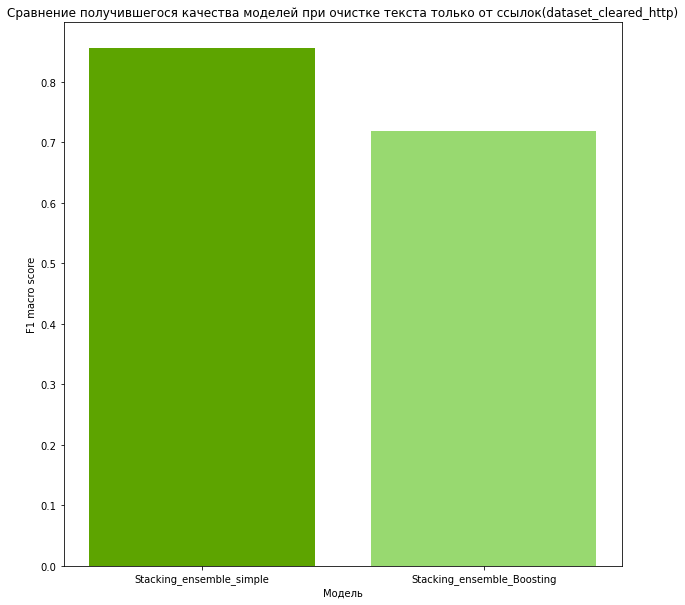

In [193]:
plt.figure(figsize=(10,10))
plt.bar(["Stacking_ensemble_simple", "Stacking_ensemble_Boosting"], [0.8555, 0.7179], color=["#5da400", "#98d970"])
plt.title('Сравнение получившегося качества моделей при очистке текста только от ссылок(dataset_cleared_http)')
plt.xlabel('Модель')
plt.ylabel('F1 macro score')
plt.show()

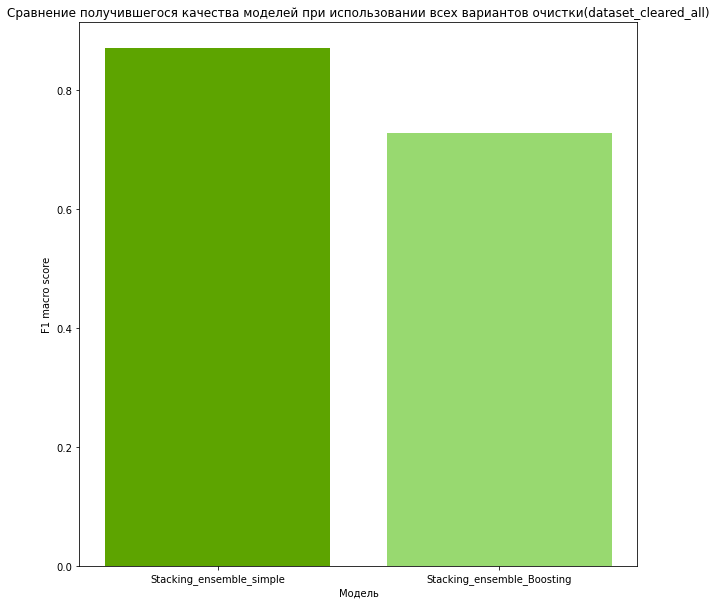

In [194]:
plt.figure(figsize=(10,10))
plt.bar(["Stacking_ensemble_simple", "Stacking_ensemble_Boosting"], [0.8708, 0.7283], color=["#5da400", "#98d970"])
plt.title('Сравнение получившегося качества моделей при использовании всех вариантов очистки(dataset_cleared_all)')
plt.xlabel('Модель')
plt.ylabel('F1 macro score')
plt.show()

не успел провести эксперименты со всеми датасетами, обучение Boosting моделей заняло слишком много времени